In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import  accuracy_score ,classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'sklearn'

In [67]:
# Load cleaned data
employees = pd.read_csv('./Preparation/cleaned_employees.csv')
performance_metrics = pd.read_csv('./Preparation/cleaned_performance_metrics.csv')

# Merge data to get a comprehensive view
data = pd.merge(employees, performance_metrics, on='employee_id')

# Explore the data
print(data.head())
print(data.info())
print(data.describe())


                            employee_id            name  \
0  0cc78cb7-acac-4a29-b18a-dc3c3a3728e5     Michael Lee   
1  0cc78cb7-acac-4a29-b18a-dc3c3a3728e5     Michael Lee   
2  484156ee-47dd-4bb0-951a-efff367523e7  Katelyn Martin   
3  936c63e1-e491-4c7d-bccb-257c60397a66   Jonathan Mays   
4  9431fdb1-9954-41c1-801a-ba80818c6d6f   Andrew Nelson   

                   email    password   phone_num designation   hire_date  \
0  michael03@example.com  i#4_UaAt&b  4756308895       Sales  2021-01-20   
1  michael03@example.com  i#4_UaAt&b  4756308895       Sales  2021-01-20   
2     vyoder@example.org  rOx+$8Tel1   510905464   Developer  2022-01-29   
3    lhudson@example.net  @A*i4#Dif5  4730992572     Manager  2021-05-28   
4   lhiggins@example.net  $y%9T$Vr78   254611318     Manager  2022-09-04   

                              metric_id                             course_id  \
0  29a8cd6b-1a61-4c81-abc0-0d3bbfb2d603  c55f69cf-ab71-4aec-bc77-b7657601b1bd   
1  2894246b-13f2-4670-8a4d

In [68]:
# Combine punctuality and discipline into a single feature
data['punctuality_discipline'] = (data['punctuality'] + data['discipline']) / 2  # Average of the two features

# Define a strict and lenient threshold for Promotion_Status
def define_promotion_status(row):
    criteria_met = 0
    lenient_criteria_met = 0  # For lenient review status

    # Check individual criteria for strict promotion
    if row['quiz_score'] > 8:
        criteria_met += 1
    if row['punctuality_discipline'] >= 4:  # Check the combined feature
        criteria_met += 1
    if row['teamwork'] >= 4:
        criteria_met += 1
    if row['communication'] >= 4:
        criteria_met += 1
    if row['problem_solving'] >= 4:
        criteria_met += 1

    # Define lenient criteria: count how many are >= 3 for lenient consideration
    if row['quiz_score'] >= 6:
        lenient_criteria_met += 1
    if row['punctuality_discipline'] >= 3:  # Slightly lower threshold
        lenient_criteria_met += 1
    if row['teamwork'] >= 3:
        lenient_criteria_met += 1
    if row['communication'] >= 3:
        lenient_criteria_met += 1
    if row['problem_solving'] >= 3:
        lenient_criteria_met += 1

    # Determine promotion status based on the number of criteria met
    if criteria_met >= 4:  # Changed from 5 to 4 for a stricter promotion count
        return 'Promote'
    elif lenient_criteria_met >= 4:
        return 'Review'  # Indicate that this employee should be reviewed
    else:
        return 'Do Not Promote'

# Apply the function to create the Promotion_Status column
data['Promotion_Status'] = data.apply(define_promotion_status, axis=1)

# Set criteria for layoffs
def define_layoff_status(row):
    # If an employee meets all the following conditions, they are flagged for layoff
    if (
        row['quiz_score'] < 4 and
        row['punctuality'] < 3 and
        row['discipline'] < 3 and
        row['teamwork'] < 3 and
        row['communication'] < 3 and
        row['problem_solving'] < 3
    ):
        return 'Layoff'
    return 'Stay'

# Apply the function to create the Layoff_Status column
data['Layoff_Status'] = data.apply(define_layoff_status, axis=1)

# Check the distribution of the target variable
print(data['Promotion_Status'].value_counts())
print(data['Layoff_Status'].value_counts())

# Optional: Drop the combined feature if not needed for further analysis
data.drop(columns=['punctuality_discipline'], inplace=True)

Promotion_Status
Do Not Promote    826
Review            152
Promote            22
Name: count, dtype: int64
Layoff_Status
Stay      989
Layoff     11
Name: count, dtype: int64


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   employee_id       1000 non-null   object
 1   name              1000 non-null   object
 2   email             1000 non-null   object
 3   password          1000 non-null   object
 4   phone_num         1000 non-null   int64 
 5   designation       1000 non-null   object
 6   hire_date         1000 non-null   object
 7   metric_id         1000 non-null   object
 8   course_id         1000 non-null   object
 9   quiz_score        1000 non-null   int64 
 10  discipline        1000 non-null   int64 
 11  punctuality       1000 non-null   int64 
 12  teamwork          1000 non-null   int64 
 13  communication     1000 non-null   int64 
 14  problem_solving   1000 non-null   int64 
 15  date              1000 non-null   object
 16  comments          1000 non-null   object
 17  Promotion_Statu

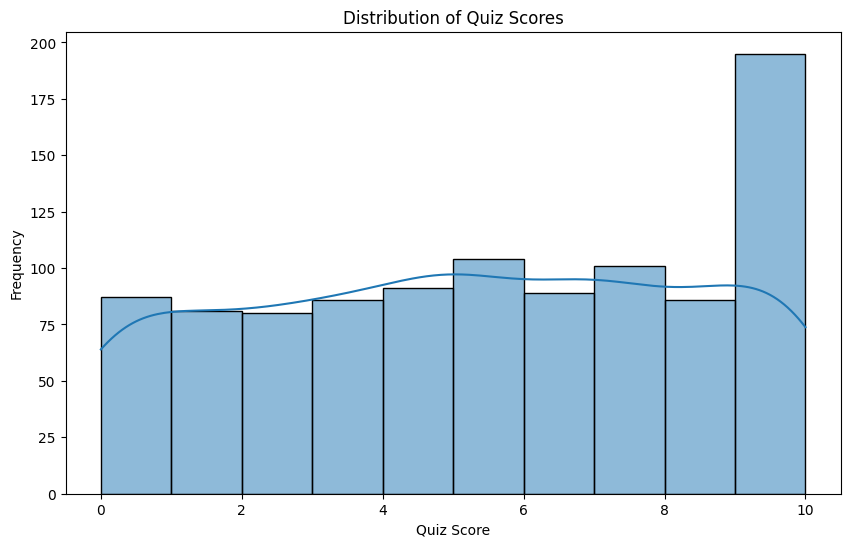

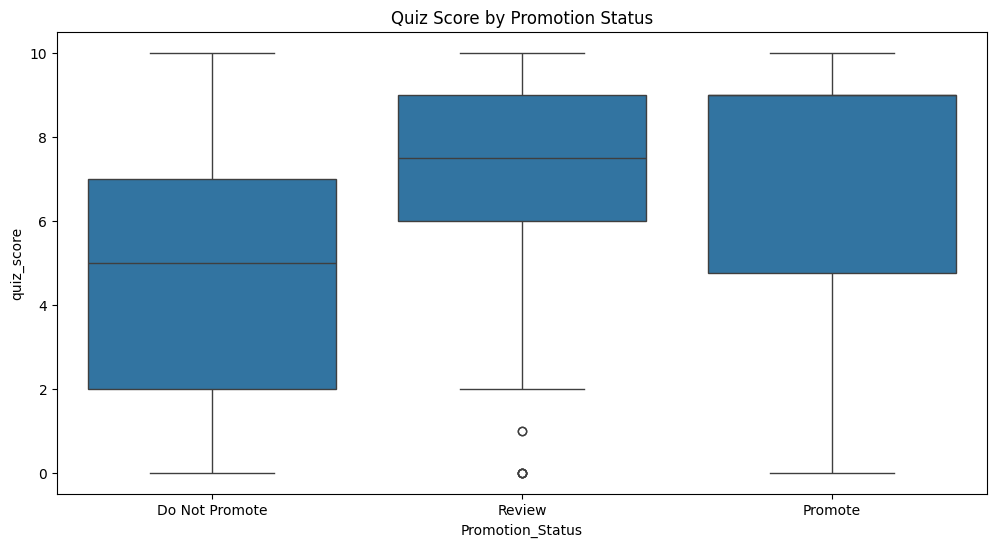

In [70]:
plt.figure(figsize=(10, 6))
sns.histplot(data['quiz_score'], bins=10, kde=True)
plt.title('Distribution of Quiz Scores')
plt.xlabel('Quiz Score')
plt.ylabel('Frequency')
plt.show()

# Boxplot for performance metrics by promotion status
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Promotion_Status', y='quiz_score')
plt.title('Quiz Score by Promotion Status')
plt.show()

In [71]:
# Combine punctuality and discipline into a single feature
data['punctuality_discipline'] = (data['punctuality'] + data['discipline']) / 2

# Drop the original columns if no longer needed
data.drop(['punctuality', 'discipline'], axis=1, inplace=True)


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   employee_id             1000 non-null   object 
 1   name                    1000 non-null   object 
 2   email                   1000 non-null   object 
 3   password                1000 non-null   object 
 4   phone_num               1000 non-null   int64  
 5   designation             1000 non-null   object 
 6   hire_date               1000 non-null   object 
 7   metric_id               1000 non-null   object 
 8   course_id               1000 non-null   object 
 9   quiz_score              1000 non-null   int64  
 10  teamwork                1000 non-null   int64  
 11  communication           1000 non-null   int64  
 12  problem_solving         1000 non-null   int64  
 13  date                    1000 non-null   object 
 14  comments                1000 non-null   o

In [72]:
# Convert categorical columns to numerical
data_encoded = pd.get_dummies(data, columns=['designation', 'Promotion_Status', 'Layoff_Status'], drop_first=True)


In [73]:
# Check the columns in the data_encoded DataFrame
print(data_encoded.columns)


Index(['employee_id', 'name', 'email', 'password', 'phone_num', 'hire_date',
       'metric_id', 'course_id', 'quiz_score', 'teamwork', 'communication',
       'problem_solving', 'date', 'comments', 'punctuality_discipline',
       'designation_HR', 'designation_Manager', 'designation_Sales',
       'Promotion_Status_Promote', 'Promotion_Status_Review',
       'Layoff_Status_Stay'],
      dtype='object')


In [74]:
# Drop unwanted features before model preparation
X = data_encoded.drop(columns=[
    'Promotion_Status_Promote', 
    'Promotion_Status_Review', 
    'Layoff_Status_Stay', 
    'employee_id', 
    'name', 
    'email', 
    'password', 
    'phone_num', 
    'metric_id', 
    'course_id', 
    'hire_date',
    'date', 
    'comments'
], errors='ignore')


In [75]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   quiz_score              1000 non-null   int64  
 1   teamwork                1000 non-null   int64  
 2   communication           1000 non-null   int64  
 3   problem_solving         1000 non-null   int64  
 4   punctuality_discipline  1000 non-null   float64
 5   designation_HR          1000 non-null   bool   
 6   designation_Manager     1000 non-null   bool   
 7   designation_Sales       1000 non-null   bool   
dtypes: bool(3), float64(1), int64(4)
memory usage: 42.1 KB


# Define Target Variable 

In [76]:

y_promotion = data_encoded['Promotion_Status_Promote']
y_review = data_encoded['Promotion_Status_Review']
y_layoff = data_encoded['Layoff_Status_Stay']


In [79]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}


def train_and_evaluate(X, y, model_dict):
    results = {}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for model_name, model in model_dict.items():
        model.fit(X_train, y_train)  # Fit the model
        y_pred = model.predict(X_test)  # Make predictions
        
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

     
        positive_class = '1' if '1' in report else list(report.keys())[-1]  
        
        results[model_name] = {
            'Accuracy': accuracy,
            'Precision': report[positive_class]['precision'],
            'Recall': report[positive_class]['recall'],
            'F1-Score': report[positive_class]['f1-score']
        }
    
    return pd.DataFrame(results).T

# Step 6: Train and Evaluate Models for Each Target Variable
results_promotion = train_and_evaluate(X, y_promotion, models)
results_review = train_and_evaluate(X, y_review, models)
results_layoff = train_and_evaluate(X, y_layoff, models)

# Step 7: Print Results
print("Promotion Model Results:")
print(results_promotion)
print("\nReview Model Results:")
print(results_review)
print("\nLayoff Model Results:")
print(results_layoff)

# Step 8: Suggest the Best Model for Each Target Variable
best_promotion_model = results_promotion['Accuracy'].idxmax()
best_review_model = results_review['Accuracy'].idxmax()
best_layoff_model = results_layoff['Accuracy'].idxmax()

print(f"\nBest model for Promotion: {best_promotion_model}")
print(f"Best model for Review: {best_review_model}")
print(f"Best model for Layoff: {best_layoff_model}")

c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Promotion Model Results:
                        Accuracy  Precision  Recall  F1-Score
Logistic Regression        0.995   0.995025   0.995  0.994649
Decision Tree              1.000   1.000000   1.000  1.000000
Random Forest              1.000   1.000000   1.000  1.000000
Support Vector Machine     0.980   0.960400   0.980  0.970101

Review Model Results:
                        Accuracy  Precision  Recall  F1-Score
Logistic Regression         0.88   0.870255    0.88  0.873829
Decision Tree               0.99   0.990000    0.99  0.990000
Random Forest               0.97   0.969735    0.97  0.969019
Support Vector Machine      0.90   0.900000    0.90  0.900000

Layoff Model Results:
                        Accuracy  Precision  Recall  F1-Score
Logistic Regression        0.985   0.980050   0.985  0.982519
Decision Tree              0.995   0.995025   0.995  0.994173
Random Forest              0.995   0.995025   0.995  0.994173
Support Vector Machine     0.990   0.980100   0.990  0.985025

c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
